In [1]:
import numpy as np
import pandas as pd
from typing import Optional, Union, Tuple
import matplotlib.pyplot as plt
import json
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
from fetch_coint_fn import fetch_coint_pairs

## Detect and get params

In [3]:
def calculate_params(series1, series2):
    """
    用 OLS 回歸 series1 = a + b * series2，計算 intercept 和 beta，用來建立 spread
    """
    x_with_const = sm.add_constant(series2)
    model = sm.OLS(series1, x_with_const)
    results = model.fit()
    intercept, beta = results.params
    return intercept, beta

def get_spread(series1, series2, beta):
    """
    spread = series1 - b * series2
    """
    spread = series1 - (beta * series2)
    return spread

def get_zscore(spread):
    """
    對 spread 計算 z-score，代表當下價差距離歷史均值幾個標準差，用來決定進出場時機
    """
    mean = np.mean(spread)
    std = np.std(spread)
    zscore = (spread - mean) / std
    return zscore

## Backtesting

In [4]:
def get_raw_df(symbol1, symbol2, df1, df2):
    """
    整合兩個標的資料成單一 DataFrame
    Spread = P1 - beta * P2
    long spread = long P1, short P2
    """
    if len(df1) != len(df2):
        return None

    raw_df = pd.DataFrame()

    raw_df = pd.concat([df1, df2], axis = 1)
    raw_df.columns = [
        "Timestamp", f"Open_{symbol1}", f"High_{symbol1}", f"Low_{symbol1}", f"Close_{symbol1}", f"Volume_{symbol1}", f"Turnover_{symbol1}",
        "Timestamp", f"Open_{symbol2}", f"High_{symbol2}", f"Low_{symbol2}", f"Close_{symbol2}", f"Volume_{symbol2}", f"Turnover_{symbol2}"
        ]
    raw_df = raw_df.loc[:,~raw_df.columns.duplicated()]
    raw_df.set_index("Timestamp", inplace = True)
    raw_df.index = pd.to_datetime(raw_df.index)

    raw_df["beta"] = calculate_params(raw_df[f"Close_{symbol1}"], raw_df[f"Close_{symbol2}"])[1]
    raw_df["spread"] = get_spread(raw_df[f"Close_{symbol1}"], raw_df[f"Close_{symbol2}"], raw_df["beta"])
    Z = get_zscore(raw_df["spread"])

    raw_df["Z_score"] = Z
    raw_df["Entry_long"] = Z < -2
    raw_df["Exit_long"] = Z >= -0.5
    raw_df["Entry_short"] = Z > 2
    raw_df["Exit_short"] = Z <= 0.75

    cols_to_numeric = [
        f"Open_{symbol1}", f"High_{symbol1}", f"Low_{symbol1}", f"Close_{symbol1}", f"Volume_{symbol1}", f"Turnover_{symbol1}",
        f"Open_{symbol2}", f"High_{symbol2}", f"Low_{symbol2}", f"Close_{symbol2}", f"Volume_{symbol2}", f"Turnover_{symbol2}",
    ]
    raw_df[cols_to_numeric] = raw_df[cols_to_numeric].astype(float)

    return raw_df

In [5]:
def backtest(raw_df: Optional[pd.DataFrame], symbol1: str, symbol2: str, window_start = 0, window_end = None, Spot_fund: float = 10000, cost: float = 0.001):
    if raw_df is None:
        return None

    if window_start == 0 and window_end is None:
        testing_data = raw_df.copy()
    else:
        testing_data = raw_df.loc[window_start: window_end].copy()
    
    BS = None
    cols_to_init = [f"Spotsize_{symbol1}", f"Spotsize_{symbol2}", "Profit", "Profitfee", "cumReturn", "Drawdown"]
    testing_data[cols_to_init] = 0.0

    for i in range(len(testing_data) - 1):
        Timestamp = testing_data.index[i]
        nextTimestamp = testing_data.index[i + 1]

        if i == len(testing_data) - 1:
            if BS in ["B", "S"]:
                if (BS == "B" and testing_data["Exit_long"].iloc[i]) or (BS == "S" and testing_data["Exit_short"].iloc[i]):
                    BS = None
                    exit_price1 = testing_data.loc[nextTimestamp, f"Open_{symbol1}"]
                    exit_price2 = testing_data.loc[nextTimestamp, f"Open_{symbol2}"]
                    cost_amount = (
                        abs(testing_data.loc[nextTimestamp, f"Spotsize_{symbol1}"]) * exit_price1 * cost + # type: ignore
                        abs(testing_data.loc[nextTimestamp, f"Spotsize_{symbol2}"]) * exit_price2 * cost # type: ignore
                    )
                    testing_data.loc[Timestamp, "Profitfee"] = testing_data.loc[Timestamp, "Profitfee"] - cost_amount # type: ignore
                    testing_data.loc[nextTimestamp, f"Spotsize_{symbol1}"] = 0
                    testing_data.loc[nextTimestamp, f"Spotsize_{symbol2}"] = 0
                    break

        if BS is None:
            if testing_data["Entry_long"].iloc[i]:
                BS = "B"
                entry_price1 = testing_data.loc[nextTimestamp, f"Open_{symbol1}"]
                entry_price2 = testing_data.loc[nextTimestamp, f"Open_{symbol2}"]
                testing_data.loc[nextTimestamp, f"Spotsize_{symbol1}"] = (Spot_fund / 2) / testing_data[f"Open_{symbol1}"].iloc[i]
                testing_data.loc[nextTimestamp, f"Spotsize_{symbol2}"] = - (Spot_fund / 2) / testing_data[f"Open_{symbol2}"].iloc[i]

            elif testing_data["Entry_short"].iloc[i]:
                BS = "S"
                entry_price1 = testing_data.loc[nextTimestamp, f"Open_{symbol1}"]
                entry_price2 = testing_data.loc[nextTimestamp, f"Open_{symbol2}"]
                testing_data.loc[nextTimestamp, f"Spotsize_{symbol1}"] = - (Spot_fund / 2) / testing_data[f"Open_{symbol1}"].iloc[i]
                testing_data.loc[nextTimestamp, f"Spotsize_{symbol2}"] = (Spot_fund / 2) / testing_data[f"Open_{symbol2}"].iloc[i]
        
        elif BS in ["B", "S"]:
            testing_data.loc[nextTimestamp, f"Spotsize_{symbol1}"] = testing_data.loc[Timestamp, f"Spotsize_{symbol1}"]
            testing_data.loc[nextTimestamp, f"Spotsize_{symbol2}"] = testing_data.loc[Timestamp, f"Spotsize_{symbol2}"]
            testing_data.loc[Timestamp, "Profit"] = (
                (testing_data.loc[nextTimestamp, f"Open_{symbol1}"] - testing_data.loc[Timestamp, f"Open_{symbol1}"]) * testing_data[f"Spotsize_{symbol1}"].iloc[i] + # type: ignore
                (testing_data.loc[nextTimestamp, f"Open_{symbol2}"] - testing_data.loc[Timestamp, f"Open_{symbol2}"]) * testing_data[f"Spotsize_{symbol2}"].iloc[i] # type: ignore
                )
            
            if testing_data["Profit"].iloc[i - 1] == 0 and testing_data["Profit"].iloc[i] != 0:
                cost_amount = (
                    abs(testing_data.loc[nextTimestamp, f"Spotsize_{symbol1}"]) * entry_price1 * cost + # type: ignore
                    abs(testing_data.loc[nextTimestamp, f"Spotsize_{symbol2}"]) * entry_price2 * cost # type: ignore
                    )
                testing_data.loc[Timestamp, "Profitfee"] = testing_data.loc[Timestamp, "Profit"] - cost_amount # type: ignore
            else:
                testing_data.loc[Timestamp, "Profitfee"] = testing_data.loc[Timestamp, "Profit"]
            
            if (BS == "B" and testing_data["Exit_long"].iloc[i]) or (BS == "S" and testing_data["Exit_short"].iloc[i]):
                BS = None
                exit_price1 = testing_data.loc[nextTimestamp, f"Open_{symbol1}"]
                exit_price2 = testing_data.loc[nextTimestamp, f"Open_{symbol2}"]
                cost_amount = (
                    abs(testing_data.loc[nextTimestamp, f"Spotsize_{symbol1}"]) * exit_price1 * cost + # type: ignore
                    abs(testing_data.loc[nextTimestamp, f"Spotsize_{symbol2}"]) * exit_price2 * cost # type: ignore
                )
                testing_data.loc[Timestamp, "Profitfee"] = testing_data.loc[Timestamp, "Profitfee"] - cost_amount # type: ignore
                testing_data.loc[nextTimestamp, f"Spotsize_{symbol1}"] = 0
                testing_data.loc[nextTimestamp, f"Spotsize_{symbol2}"] = 0

    testing_data["cumReturn"] = testing_data["Profitfee"].cumsum()
    peak = testing_data["cumReturn"].cummax()
    testing_data["Drawdown"] = - (testing_data["cumReturn"] - peak) / peak

    return testing_data

In [6]:
def get_performance_dynamic(df: pd.DataFrame):
    df["cumReturn"] = df["Profitfee"].cumsum()
    peak = df["cumReturn"].cummax()
    try:
        df["Drawdown"] = - (df["cumReturn"] - peak) / peak
    except:
        df["Drawdown"] = 0
        
    return df

In [7]:
def get_performance_steady(df: pd.DataFrame, cost: float, p_value: float, freq_per_day: int = 24):
    if df is None:
        return None
    
    performance = {}
    profit_series = df["Profitfee"].dropna()
    negative_profit = profit_series[profit_series < 0]
    positive_profit = profit_series[profit_series > 0]

    performance["totalReturn"] = df["Profit"].sum()
    performance["totalProfitfee"] = df["Profitfee"].sum()
    performance["AnnualizedReturn"] = profit_series.mean() * freq_per_day * 365
    performance["Win Rate"] = len(positive_profit) / len(profit_series) if len(profit_series) != 0 else 0
    performance["SharpeRatio"] = profit_series.mean() / profit_series.std() if profit_series.std() != 0 else np.nan
    performance["SortinoRatio"] = profit_series.mean() / negative_profit.std() if negative_profit.std() != 0 else np.nan
    performance["ProfitFactor"] = positive_profit.sum() / abs(negative_profit.sum()) if abs(negative_profit.sum()) != 0 else np.inf
    performance["MaxDrawdown"] = df["Drawdown"].min()
    performance["Coin_p_value"] = - p_value # 寫負的之後排序比較好排

    return performance

In [8]:
def get_new_main_df(df: pd.DataFrame, symbol1: str, symbol2: str):
    """
    從單對測試資料中擷取 Profit、Profitfee
    """
    new_main_df = df[["Profit", "Profitfee"]].copy()
    new_main_df["Timestamp"] = df.index
    new_main_df["Pairs"] = (symbol1 + " - " + symbol2)
    new_main_df["Pairs"] = new_main_df["Pairs"].astype("category")

    cols = ["Pairs", "Profit", "Profitfee"]
    new_main_df = new_main_df[cols]

    return new_main_df

In [9]:
def get_transaction_logs(trade_details: list, testing_df: pd.DataFrame, symbol1: str, symbol2: str):
    testing_df.index = pd.to_datetime(testing_df.index)
    entry_time = entry_price1 = entry_price2 = size1 = size2 = None

    for i in range(1, len(testing_df)):
        entry = testing_df[f"Spotsize_{symbol1}"].iloc[i] != 0 and testing_df[f"Spotsize_{symbol1}"].iloc[i - 1] == 0
        exit = testing_df[f"Spotsize_{symbol1}"].iloc[i] == 0 and testing_df[f"Spotsize_{symbol1}"].iloc[i - 1] != 0
        if entry:
            entry_time = testing_df.index[i]
            entry_price1 = testing_df[f"Open_{symbol1}"].iloc[i]
            entry_price2 = testing_df[f"Open_{symbol2}"].iloc[i]
            size1 = testing_df[f"Spotsize_{symbol1}"].iloc[i]
            size2 = testing_df[f"Spotsize_{symbol2}"].iloc[i]

        elif exit:
            exit_time = testing_df.index[i]
            exit_price1 = testing_df[f"Open_{symbol1}"].iloc[i]
            exit_price2 = testing_df[f"Open_{symbol2}"].iloc[i]
            profitfee = testing_df.loc[entry_time: exit_time, "Profitfee"].cumsum().iloc[-1]
            holding_period = exit_time - entry_time

            trade_details.append({
                "Pairs": f"{symbol1} - {symbol2}",
                "EntryTime": entry_time,
                "Size1": size1,
                "EntryPrice1": entry_price1,
                "EntryPrice2": entry_price2,
                "ExitTime": exit_time,
                "Size2": size2,
                "ExitPrice1": exit_price1,
                "ExitPrice2": exit_price2,
                "HoldingPeriod": holding_period,
                "Profitfee": profitfee
            })

    
    return trade_details

In [10]:
def rolling(main_df: pd.DataFrame, train_ratio: float, n_window: int, num_pair_select: Union[int, str], spot_sector_map: str, spot_folder: str, cost: float, focus_indicator: str = "totalReturn"):
    """
    有時候不能整除，所以可能會多一個window
    """
    total_size = len(main_df)
    test_ratio = 1 - train_ratio
    trade_details = []
    
    window = total_size // (1 + test_ratio * (n_window - 1))
    train_size = int(window * train_ratio)
    test_size = int(window * test_ratio)

    start = 0
    window_num = 0
    main_df[["Profit", "Profitfee"]] = 0

    while start + train_size + test_size <= total_size:
        print(f"Processing window {window_num + 1}")

        train_results = []
        train = main_df.iloc[start : start + train_size]
        train_start_time = train.index[0]
        train_end_time = train.index[-1]
        print(f"{train_start_time}-{train_end_time}")
        
        # fetch cointegrated pairs by parralel processing(up to 8 workers)
        coint_pairs = fetch_coint_pairs(spot_sector_map, spot_folder, train_start_time, train_end_time, max_workers = 6)
        for pair_data in coint_pairs:
            sector = pair_data["sector"]
            symbol1, symbol2 = pair_data["pair"][0], pair_data["pair"][1]

            df1 = pd.read_csv(f"{spot_folder}/{symbol1}.csv")
            df2 = pd.read_csv(f"{spot_folder}/{symbol2}.csv")
            raw_df = get_raw_df(symbol1, symbol2, df1, df2)
            training_df = backtest(raw_df, symbol1, symbol2, train_start_time, train_end_time)
            if training_df is None:
                continue
            p_value = pair_data["p_value"]
            performance = get_performance_steady(training_df, cost, p_value)
            train_results.append({
                "sector": sector,
                "pair": (symbol1, symbol2),
                "performance": performance
            })

        sorted_results = sorted(train_results, key = lambda x: x["performance"][focus_indicator], reverse = True)
        sorted_df = pd.DataFrame(sorted_results)
        sorted_df.to_csv("sorted_results.csv")
        if num_pair_select == "all":
            num_pair_select = len(sorted_results)
        selected_pair = sorted_results[0: num_pair_select]
        
        # 挑較好的交易對做交易
        for pair in selected_pair:
            symbol1, symbol2 = pair["pair"][0], pair["pair"][1]
            
            test = main_df.iloc[start + train_size : start + train_size + test_size]
            testing_start_time = test.index[0]
            testing_end_time = test.index[-1]

            df1 = pd.read_csv(f"{spot_folder}/{symbol1}.csv")
            df2 = pd.read_csv(f"{spot_folder}/{symbol2}.csv")
            raw_df = get_raw_df(symbol1, symbol2, df1, df2)
            testing_df = backtest(raw_df, symbol1, symbol2, testing_start_time, testing_end_time)
            if testing_df is not None:
                testing_df.to_csv("test.csv")
            else:
                print(f"raw_df of window {window_num + 1} is None")
                continue

            new_main_df = get_new_main_df(testing_df, symbol1, symbol2)
            main_df[["Profit", "Profitfee"]] = main_df[["Profit", "Profitfee"]].add(new_main_df[["Profit", "Profitfee"]], fill_value = 0)
            trade_details = get_transaction_logs(trade_details, testing_df, symbol1, symbol2)
        
        start += test_size
        window_num += 1

    trade_details = pd.DataFrame(trade_details)
    trade_details.sort_values(by = "EntryTime", inplace = True)

    main_df = get_performance_dynamic(main_df)
        
    return main_df, trade_details

In [11]:
spot_sector = "/Users/xinc./Documents/GitHub/Quant/data/crypto_database/metadata/spot_sector_map.json"
spot_folder = "/Users/xinc./Documents/GitHub/Quant/data/crypto_database/spot"

with open(spot_sector, "r") as f:
    spot_sector_map = json.load(f)

start = "2022-01-01 00:00:00+08:00"
end = "2025-03-30 21:00:00+08:00"
train_interval = 2 # months
test_interval = 1 # months

main_df = pd.DataFrame(index = pd.date_range(start, end, freq = "h"), columns = ["Profit", "Profitfee", "cumReturn", "Drawdown"])
train_size, test_size = train_interval * 30 * 24, test_interval * 30 * 24
window_size = train_size + test_size
train_ratio = train_size / (train_size + test_size)
n_window = (len(main_df) - train_size - test_size) // test_size + 1

In [12]:
print(train_size, test_size, window_size, train_ratio, n_window)

1440 720 2160 0.6666666666666666 37


In [13]:
main_df, trade_details = rolling(
    main_df = main_df,
    train_ratio = train_ratio,
    n_window = n_window,
    num_pair_select = "all", # number or "all"
    spot_sector_map = spot_sector_map,
    spot_folder = spot_folder,
    cost = 0.001,
    focus_indicator = "Coin_p_value"
)
main_df.to_csv("main_df.csv")
trade_details.to_csv("transaction_logs.csv", index = False)

Processing window 1
2022-01-01 00:00:00+08:00-2022-03-02 17:00:00+08:00
Processing window 2
2022-01-31 09:00:00+08:00-2022-04-02 02:00:00+08:00
Processing window 3
2022-03-02 18:00:00+08:00-2022-05-02 11:00:00+08:00
Processing window 4
2022-04-02 03:00:00+08:00-2022-06-01 20:00:00+08:00
Processing window 5
2022-05-02 12:00:00+08:00-2022-07-02 05:00:00+08:00
Processing window 6
2022-06-01 21:00:00+08:00-2022-08-01 14:00:00+08:00
Processing window 7
2022-07-02 06:00:00+08:00-2022-08-31 23:00:00+08:00
Processing window 8
2022-08-01 15:00:00+08:00-2022-10-01 08:00:00+08:00
Processing window 9
2022-09-01 00:00:00+08:00-2022-10-31 17:00:00+08:00
Processing window 10
2022-10-01 09:00:00+08:00-2022-12-01 02:00:00+08:00
Processing window 11
2022-10-31 18:00:00+08:00-2022-12-31 11:00:00+08:00
Processing window 12
2022-12-01 03:00:00+08:00-2023-01-30 20:00:00+08:00
Processing window 13
2022-12-31 12:00:00+08:00-2023-03-02 05:00:00+08:00
Processing window 14
2023-01-30 21:00:00+08:00-2023-04-01 14

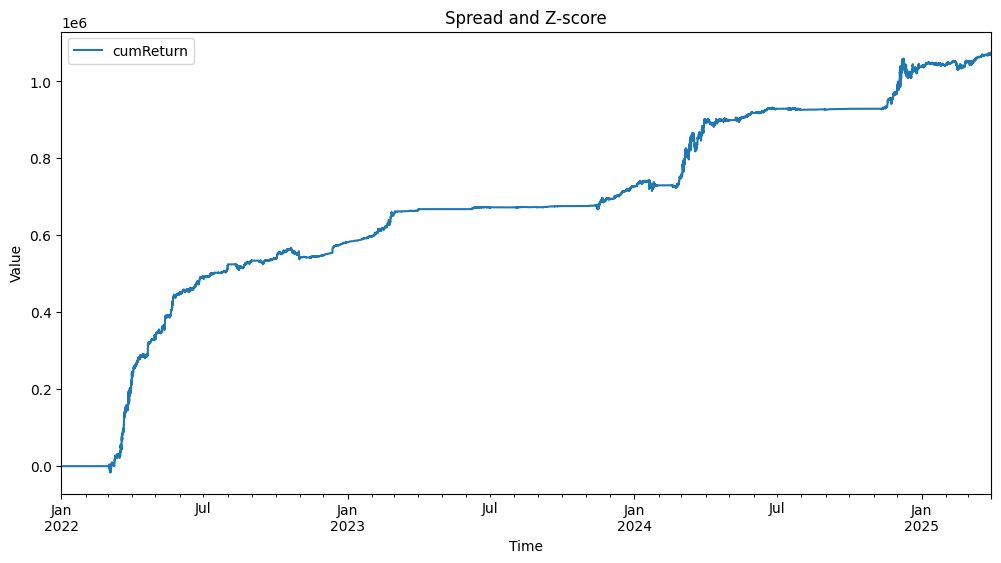

In [14]:
ax = main_df[["cumReturn"]].plot(figsize = (12, 6))

plt.legend()
plt.title("Spread and Z-score")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

0


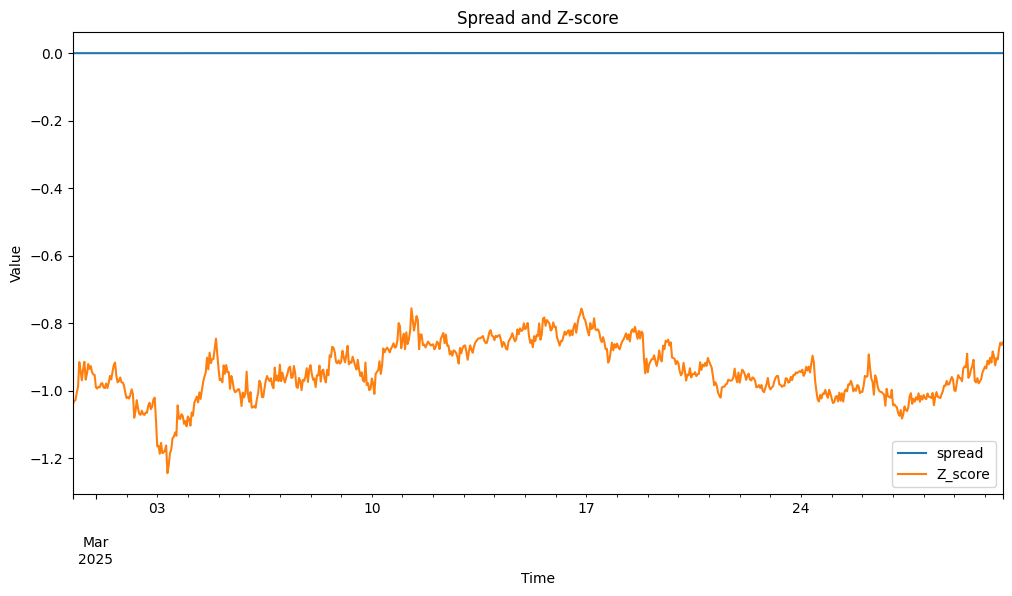

In [15]:
test = pd.read_csv("test.csv")
test["Timestamp"] = pd.to_datetime(test["Timestamp"])
test.set_index("Timestamp", inplace=True)

print(test["Entry_short"].sum())

ax = test[['spread', "Z_score"]].plot(figsize = (12, 6))

plt.legend()
plt.title("Spread and Z-score")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()